Before running any code, please make sure the required Python packages are installed by using the below command.

In [ ]:
!pip install requirements.txt

# Intro

This notebook contains code that accesses, samples, and compares four satellite-derived ice velocity datasets. Specifically, comparisons are made between four ice velocity datasets each derived from feature tracking of Sentinel-1 radar image pairs. The four datasets are: ENVEO, ITS_LIVE, MEaSUREs, and PROMICE. Information including links to relevant documentation and data portals are provided in their respective sections below.

As well as comparing ice velocity between the four datasets, some rough validation is performed for two of the datasets against GPS-derived ice velocities.

# AOI geometry

First, this plot shows the area of interest around Russell Glacier (red box) and the most recent locations of four Automatic Weather Stations (blue crosses) used as points to sample ice velocity datasets.

For a more interactive view, see the `velocity.qgz` QGIS project, which is populated with various useful layers.

<Axes: >

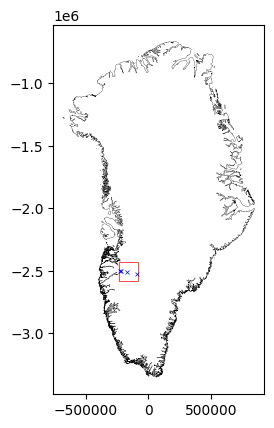

In [1]:
import geopandas as gpd

aoi_gdf = gpd.read_file("./data/misc/russell_3.geojson")
aoi_bbox = aoi_gdf.total_bounds
aoi_bbox_x = slice(aoi_bbox[0], aoi_bbox[2])
aoi_bbox_y = slice(aoi_bbox[3], aoi_bbox[1])

aws_gdf = gpd.read_file("./data/gps/aws.geojson").to_crs(3413).set_index("stid")
aws_x = aws_gdf.geometry.x.to_xarray()
aws_y = aws_gdf.geometry.x.to_xarray()

gis_gdf = gpd.read_file("./data/misc/coastline.geojson")
ax = gis_gdf.plot(facecolor="white", edgecolor="black", linewidth=0.20)
aoi_gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.50)
aws_gdf.plot(ax=ax, facecolor="blue", linewidth=0.50, marker="x", markersize=8)

# Velocity datasets

## ENVEO

ENVEO IT GmbH produces ice velocity datasets covering Greenland for the European Space Agency (ESA), previously as a part of the Greenland Ice Sheet Climate Change Initiative (CCI) and currently through the Copernicus Climate Change Service (C3S). 

These data are derived by applying offset tracking techniques using Sentinel-1 synthetic aperture radar (SAR) data acquired in the Interferometric Wide (IW) swath mode.

### Annual

Annual velocity grids are freely and openly available for 2017-2021 through the Copernicus Climate Data Store (CDS). These data are thoroughly documented here: https://confluence.ecmwf.int/pages/viewpage.action?pageId=414590402

Here, the CDS API is used to download all annual ice velocity maps. Each map, provided as a single NETCDF file, are opened and 'stacked' together to produce one single dataset that can be accessed and queried across space (x and y dimensions) and time (each year). This stacked dataset is subset to our AOI and saved to disk as the file: 

`./data/enveo/gis_iv_250m_s1_s20170101_e20211231_v1_3_russell_annual.netcdf`

In [ ]:
import os
import zipfile

import cdsapi

dataset = "satellite-greenland-ice-sheet-velocity"
request = {
    "variable": "all",
    "period": [
        "2017_2018",
        "2018_2019",
        "2019_2020",
        "2020_2021",
    ],
    "version": [
        "1_3",
        "1_4",
    ],
}

client = cdsapi.Client()
result = client.retrieve(dataset, request)
target = result.download(target="./data/velocity/enveo/annual/tmp.zip")

with zipfile.ZipFile(target, "r") as zip:
    zip.extractall(os.path.dirname(target))

os.remove(target)

In [ ]:
import os
import re

import geopandas as gpd
import pandas as pd
import xarray as xr


# Function called upon openeing each annual map to assign its 'time' dimension
def preprocess(ds):
    path = ds.encoding["source"]
    filename = os.path.basename(path)
    time_start, time_end = re.findall(r"_(\d{8})_(\d{8})_", filename)[0]
    time_start = pd.to_datetime(time_start)
    time_end = pd.to_datetime(time_end)
    mid_date = time_start + (time_end - time_start) // 2
    ds = ds.expand_dims(time=[mid_date])

    return ds


# Uses xarray to open and 'stack' annual maps ('open_mfdataset' means open multi-file dataset)
velocity_ds = xr.open_mfdataset(
    "./data/velocity/enveo/annual/C3S_*.nc",
    preprocess=preprocess,
    parallel=True,
    combine_attrs="drop_conflicts",
)
velocity_ds = velocity_ds.sel(x=aoi_bbox_x, y=aoi_bbox_y)
velocity_ds.to_netcdf(
    "./data/velocity/enveo/gis_iv_250m_s1_s20170101_e20211231_v1_3_russell_annual.nc"
)
velocity_ds

<xarray.Dataset> Size: 46MB
Dimensions:                              (time: 4, y: 600, x: 600)
Coordinates:
  * time                                 (time) datetime64[ns] 32B 2018-04-01...
  * y                                    (y) float64 5kB -2.43e+06 ... -2.58e+06
  * x                                    (x) float64 5kB -2.349e+05 ... -8.51...
Data variables:
    crs                                  (time) int32 16B -2147483647 ... -21...
    land_ice_surface_easting_velocity    (time, y, x) float32 6MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_northing_velocity   (time, y, x) float32 6MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_vertical_velocity   (time, y, x) float32 6MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_velocity_magnitude  (time, y, x) float32 6MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_measurement_count   (time, y, x) float64 12MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_easting_stddev      (time, y, x) float32 6MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_northing_stddev     (time, y, x) float32 6MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    institution:  Copernicus Climate Change Service
    keywords:     EARTH SCIENCE CLIMATE INDICATORS CRYOSPHERIC INDICATORS GLA...
    license:      C3S general license
    project:      C3S_312b_Lot4_ice_sheets_and_shelves
    source:       Copernicus Sentinel-1A and Sentinel-1B
    title:        Ice Velocity of the Greenland Ice Sheet

### Monthly

ENVEO also produces monthly ice velocity maps that are not openely available online. These data were provided upon request to Jan Wuite [jan.wuite@enveo.at]. Here, monthly ice velocity maps are opened, stacked, spatially subset, and saved to disk as above, but only for the years 2017 and 2018. 

The resulting dataset is:

`./data/enveo/gis_iv_250m_s1_s20170101_e20211231_v1_3_russell_monthly.netcdf`

In [ ]:
import os
import re

import pandas as pd
import xarray as xr


def preprocess(ds):
    path = ds.encoding["source"]
    filename = os.path.basename(path)
    time_start, time_end = re.findall(r"_s(\d{8})_e(\d{8})_", filename)[0]
    time_start = pd.to_datetime(time_start)
    time_end = pd.to_datetime(time_end)
    mid_date = time_start + (time_end - time_start) // 2
    ds = ds.expand_dims(time=[mid_date])

    return ds


velocity_ds = xr.open_mfdataset(
    "./data/velocity/enveo/monthly/greenland_iv_*_v1_2.nc",
    preprocess=preprocess,
    parallel=True,
    combine_attrs="drop_conflicts",
)
velocity_ds = velocity_ds.sel(x=aoi_bbox_x, y=aoi_bbox_y)
velocity_ds.to_netcdf(
    "./data/velocity/enveo/gis_iv_250m_s1_s20170101_e20181231_v1_2_russell_monthly.nc"
)
velocity_ds

<xarray.Dataset> Size: 242MB
Dimensions:                              (time: 24, y: 600, x: 600)
Coordinates:
  * time                                 (time) datetime64[ns] 192B 2017-01-1...
  * y                                    (y) float64 5kB -2.43e+06 ... -2.58e+06
  * x                                    (x) float64 5kB -2.349e+05 ... -8.51...
Data variables:
    crs                                  (time) int32 96B -2147483647 ... -21...
    land_ice_surface_easting_velocity    (time, y, x) float32 35MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_northing_velocity   (time, y, x) float32 35MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_vertical_velocity   (time, y, x) float32 35MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_velocity_magnitude  (time, y, x) float32 35MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_measurement_count   (time, y, x) float64 69MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
    land_ice_surface_velocity_stddev     (time, y, x) float32 35MB dask.array<chunksize=(1, 600, 600), meta=np.ndarray>
Attributes:
    contact:        http://www.enveo.at/
    Conventions:    CF-1.7
    creation_date:  2020-02-04
    history:        Initial product version 1.2
    institution:    ENVEO
    keywords:       EARTH SCIENCE CLIMATE INDICATORS CRYOSPHERIC INDICATORS G...
    license:        general license
    project:        ESA Greenland Ice Sheet CCI+
    reference:      Main: Nagler, T.; Rott, H.; Hetzenecker, M.; Wuite, J.; P...
    source:         Copernicus Sentinel-1A and Sentinel-1B
    title:          Ice Velocity of the Greenland Ice Sheet

### 6/12-day

Both the annual and monthly datasets shown above are derived (averaged) from Sentinel-1 6/12-day image-pair velocity granules. These were also provided for 2017 and 2018 upon request but were delivered in a different format. 

Ice velocity magnitude maps (vv) were supplied as single-band GeoTIFF images. Individual component velocities (vx, vy, vz) were supplied seperately via multi-band GeoTIFF images. 

Here, the velocity magnitude maps alone are opened, stacked, spatially subset, and saved to disk as above. The difference in input format requires slightly different preprocessing steps, but the resulting dataset is similar to those produced above:

`./data/enveo/gis_iv_250m_s1_s20170101_e20211231_v1_3_russell_repeat.netcdf`

In this dataset, each velocity measurement is accompanied by a pair of datetimes that correspond to the Sentinel-1 images used to derive velocity.

In [ ]:
import numpy as np


def preprocess(ds):
    path = ds.encoding["source"]
    filename = os.path.basename(path)
    time_start, time_end = re.findall(r"_s(\d{8})_e(\d{8})_", filename)[0]
    time_start = pd.to_datetime(time_start)
    time_end = pd.to_datetime(time_end)
    mid_date = time_start + (time_end - time_start) // 2

    ds = ds.squeeze()
    ds = ds.drop_vars("band")
    ds = ds.rename(band_data="land_ice_surface_velocity_magnitude")
    ds = ds.expand_dims(time=[np.datetime64(mid_date, "ns")])
    ds["time_bnds"] = (
        ("time", "bnds"),
        [[np.datetime64(time_start, "ns"), np.datetime64(time_end, "ns")]],
    )

    return ds


velocity_ds = xr.open_mfdataset(
    "./data/velocity/enveo/repeat/mag/gis_iv_*.tif",
    preprocess=preprocess,
    parallel=True,
    combine_attrs="drop_conflicts",
)
velocity_ds = velocity_ds.sel(x=aoi_bbox_x, y=aoi_bbox_y)
velocity_ds.to_netcdf(
    "./data/velocity/enveo/gis_iv_250m_s1_s20170101_e20181231_v1_2_russell_repeat.nc"
)
velocity_ds

<xarray.Dataset> Size: 348MB
Dimensions:                              (time: 242, y: 600, x: 600, bnds: 2)
Coordinates:
  * time                                 (time) datetime64[ns] 2kB 2017-01-07...
  * x                                    (x) float64 5kB -2.349e+05 ... -8.51...
  * y                                    (y) float64 5kB -2.43e+06 ... -2.58e+06
    spatial_ref                          int32 4B 0
Dimensions without coordinates: bnds
Data variables:
    land_ice_surface_velocity_magnitude  (time, y, x) float32 348MB dask.array<chunksize=(1, 3, 600), meta=np.ndarray>
    time_bnds                            (time, bnds) datetime64[ns] 4kB 2017...

## ITS_LIVE

The ITS_LIVE (Inter-mission Time Series of Land Ice Velocity and Elevation) project run by NASA produces ice velocity data for Greenland from feature tracking of both optical (e.g., Landsat, Sentinel-2) and radar (e.g., Sentinel-1) imagery. 

The ITS_LIVE website (https://its-live.jpl.nasa.gov/) provides useful information, as does the registry of the ITS_LIVE AWS S3 Bucket (https://registry.opendata.aws/its-live-data/).

The indivdidual image-pair velocities derived from all satellites/sensors are aligned to a common grid and stacked into cloud-optimed Zarr datacubes. This format is highly optimised for fast access over the internet, but there is a lack of robust, comprehensive tools to access these data. 

### Image-pairs


Here, ITS_LIVE velocities are queried only at specific points -- the most recent locations of four PROMICE Automatic Weather Station -- as downloading the full gridded area of our AOI for every image-pair in the ITS_LIVE archive is not feasible given current tools. 

To do this, we first identify the ITS_LIVE grid cells (aka Zarr datacubes) of relevance by performing a spatial intersection between the AWS points and the ITS_LIVE metadata catalog. 

The relevant Zarr datacubes are accessed and point-queried in turn. The resulting dataset is formatted similar to those above, but with x and y dimensions replaced by the one-dimensional AWS station ID. The x and y coordinates of each station is saved in the dataset along with metadata describing error and the component images of each velocity measurement. 

`./data/velocity/its_live/gis_iv_itslive_s20170101_e20181231_russell.nc`

In [21]:
import geopandas as gpd
import xarray as xr


VARIABLES = [
    "v",
    "v_error",
    "date_dt",
    "mid_date",
    "mission_img1",
    "satellite_img1",
    "acquisition_date_img1",
    "acquisition_date_img2",
    "mapping",
]

# Read ITS_LIVE datacube catalog and reproject to EPSG:3413
its_live_catalog = gpd.read_file(
    "https://its-live-data.s3-us-west-2.amazonaws.com/datacubes/catalog_v02.json"
).to_crs(3413)

# Overlay AWS points with datacube catalog to get intersecting datacube URLs
aws_gdf = gpd.read_file("./data/gps/aws.geojson").to_crs(3413)  # .set_index("stid")
aws_gdf = aws_gdf.overlay(
    its_live_catalog[["geometry", "zarr_url"]], how="intersection"
)
aws_gdf["zarr_url"] = aws_gdf.zarr_url.str.replace("http:", "s3:")
aws_gdf["zarr_url"] = aws_gdf.zarr_url.str.replace(".s3.amazonaws.com", "")

# Container for sampled Datasets
velocity_ds = []

# Group AWS points by intersecting datacube
for zarr_url, aws_cube in aws_gdf.groupby(by="zarr_url"):
    # Open datacube
    itslive_ds = xr.open_dataset(
        zarr_url, engine="zarr", storage_options={"anon": True}
    )

    points_x = aws_cube.geometry.x.to_xarray()
    points_y = aws_cube.geometry.y.to_xarray()

    _velocity_ds = itslive_ds[VARIABLES].sel(x=points_x, y=points_y, method="nearest")
    _velocity_ds = _velocity_ds.assign_coords(index=aws_cube.stid).rename(index="stid")
    velocity_ds.append(_velocity_ds)

# Concat sampled Datasets, sort by date, and write to disk
velocity_ds = xr.combine_nested(
    velocity_ds, concat_dim="mid_date", combine_attrs="drop_conflicts"
)
velocity_ds = velocity_ds.sortby("mid_date")
velocity_ds = velocity_ds.sel(mid_date=slice("2017-01-01", "2018-12-31"))
velocity_ds.to_netcdf(
    "./data/velocity/its_live/gis_iv_itslive_s20170101_e20181231_russell.nc"
)
velocity_ds

<xarray.Dataset> Size: 3MB
Dimensions:                (mid_date: 40098, stid: 4)
Coordinates:
  * stid                   (stid) object 32B 'KAN_B' 'KAN_L' 'KAN_M' 'KAN_U'
  * mid_date               (mid_date) datetime64[ns] 321kB 2017-01-01T02:49:2...
    x                      (stid) float64 32B -2.267e+05 ... -8.959e+04
    y                      (stid) float64 32B -2.5e+06 -2.504e+06 ... -2.522e+06
Data variables:
    v                      (mid_date, stid) float32 642kB nan nan ... nan nan
    v_error                (mid_date, stid) float32 642kB nan nan ... nan nan
    date_dt                (mid_date) timedelta64[ns] 321kB 444 days 23:59:57...
    mission_img1           (mid_date) <U1 160kB 'S' 'S' 'S' 'S' ... 'S' 'S' 'S'
    satellite_img1         (mid_date) <U2 321kB '2A' '2A' '1A' ... '1A' '1A'
    acquisition_date_img1  (mid_date) datetime64[ns] 321kB 2016-05-23T14:49:2...
    acquisition_date_img2  (mid_date) datetime64[ns] 321kB 2017-08-11T14:49:1...
    mapping                (mid_date) <U1 160kB '' '' '' '' '' ... '' '' '' ''
Attributes:
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    institution:                NASA Jet Propulsion Laboratory (JPL), Califor...
    projection:                 3413
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities

## MEaSUREs

In addition to ITS_LIVE, NASA produce a number of ice velocity datasets through the MEaSUREs (Making Earth System Data Records for Use in Research Environments) programme. In paticular, the Greenland Ice sheet Mapping Project (GrIMP) includes annual, quarterly, monthly, and 6/12-day velocity datasets (see https://nsidc.org/grimp). 

The 6/12-day dataset is of most relevance here as this is the finest temproal resolution and is produced solely from feature tracking of Sentinel-1 radar data (the annual, quarterly, monthly averaged products are mosaiced with velocity data derived from Landsat 8). These data are accessed and documented here: https://nsidc.org/data/nsidc-0766/versions/2

### 6/12-day 

Lacking a robust Python API, the MEaSUREs 6/12-day ice velocity maps are downlaoded from the NSIDC web servers using a slightly ugly `wget` command. This can be used to download the data by running the batch file:

`./data/velocity/measures/nsidc-0766_s1cycles/measures_cycles_download.bat`

Unfortunately, each velocity granule is delivered as a collection of six related GeoTIFF images, with individual maps for velocity magnitude (vv), the x and y velocity components (vx, vy), error in the x and y velocity components (ex, ey), and the time seperation between image pairs (dT). For 2017 and 2018, these Greenland-wide maps total ~80 GB.

The following code wrangles these data into a format similar to the nice xarray.Dataset stacks seen above.

First, regular expressions are used to identify the individual *collections* of these GeoTIFF files based on the dates included in the filenames.

In [ ]:
import glob
import os
import re
from collections import defaultdict
from datetime import datetime
from functools import partial

import numpy as np
import xarray as xr

data_dir = "./data/velocity/measures/nsidc-0766_s1cycles"
glob_pattern = f"{data_dir}/GL_vel_mosaic_s1cycle_*.tif"
file_pattern = re.compile(
    r"GL_vel_mosaic_s1cycle_(\d{2}[A-Za-z]{3}\d{2})_(\d{2}[A-Za-z]{3}\d{2})_(dT|ex|ey|vx|vy|vv)_v02.0.tif$"
)

file_groups = defaultdict(dict)
for file_path in glob.glob(glob_pattern):
    file_name = os.path.basename(file_path)
    match = file_pattern.match(file_name)
    start_date, end_date, variable = match.groups()
    file_groups[(start_date, end_date)][variable] = file_path

Next, each *collection* of six GeoTIFFs (representing one image-pair) is stacked together and spatially subset to our AOI. This involves extracting variable the label from each filename (vv, vx, vy, ex, ey, dT) and assigning this to each layer in the stack. 

Once collated, each dataset is written to disk so that we have a single file for each image-pair.

In [ ]:
import tqdm


def _preprocess(ds, variables):
    ds = ds.squeeze()
    ds = ds.drop_vars("band")
    ds = ds.rename({list(ds.data_vars)[0]: next(variables)})
    ds = ds.transpose("x", "y")
    return ds


for (start_date, end_date), files in tqdm.tqdm(file_groups.items()):
    file_paths = iter(files.values())
    variables = iter(files.keys())

    partial_func = partial(_preprocess, variables=variables)
    ds = xr.open_mfdataset(file_paths, preprocess=partial_func, engine="rasterio")
    ds = ds.sel(x=slice(aoi_bbox[0], aoi_bbox[2]), y=slice(aoi_bbox[3], aoi_bbox[1]))

    mid_date = (
        datetime.strptime(start_date, "%d%b%y")
        + (
            datetime.strptime(end_date, "%d%b%y")
            - datetime.strptime(start_date, "%d%b%y")
        )
        / 2
    )
    ds = ds.expand_dims(time=[np.datetime64(mid_date, "ns")])

    ds["time_bnds"] = (
        ("time", "bnds"),
        [
            [
                np.datetime64(datetime.strptime(start_date, "%d%b%y"), "ns"),
                np.datetime64(datetime.strptime(end_date, "%d%b%y"), "ns"),
            ]
        ],
    )

    start_date_formatted = datetime.strptime(start_date, "%d%b%y").strftime("%Y%m%d")
    end_date_formatted = datetime.strptime(end_date, "%d%b%y").strftime("%Y%m%d")
    output_filename = f"sub_GL_vel_mosaic_s1cycle_{start_date_formatted}_{end_date_formatted}_v02.0.nc"
    ds.to_netcdf(os.path.join(data_dir, output_filename))

100%|██████████| 123/123 [00:37<00:00,  3.31it/s]


Finally, the individual subset image-pair NETCDF files are stacked together (as is done for the ENVEO image-pair data). This is written to disk as:

`./data/velocity/measures/GL_vel_mosaic_s1cycle_20170101_20181231_v02.0_russell.nc`

In [22]:
import xarray as xr

v_measures = xr.open_mfdataset("./data/velocity/measures/nsidc-0766_s1cycles/sub_*.nc")
v_measures.to_netcdf(
    "./data/velocity/measures/GL_vel_mosaic_s1cycle_20170101_20181231_v02.0_russell.nc"
)
v_measures

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 123, x: 751, y: 751, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 984B 2016-12-29T12:00:00 ... 2018-12-3...
  * x            (x) float64 6kB -2.35e+05 -2.348e+05 ... -8.52e+04 -8.5e+04
  * y            (y) float64 6kB -2.43e+06 -2.43e+06 ... -2.58e+06 -2.58e+06
Dimensions without coordinates: bnds
Data variables:
    spatial_ref  (time) float64 984B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dT           (time, x, y) float64 555MB dask.array<chunksize=(1, 751, 751), meta=np.ndarray>
    ex           (time, x, y) float64 555MB dask.array<chunksize=(1, 751, 751), meta=np.ndarray>
    ey           (time, x, y) float64 555MB dask.array<chunksize=(1, 751, 751), meta=np.ndarray>
    vv           (time, x, y) float64 555MB dask.array<chunksize=(1, 751, 751), meta=np.ndarray>
    vx           (time, x, y) float64 555MB dask.array<chunksize=(1, 751, 751), meta=np.ndarray>
    time_bnds    (time, bnds) datetime64[ns] 2kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    vy           (time, x, y) float64 555MB dask.array<chunksize=(96, 751, 751), meta=np.ndarray>

## PROMICE

GEUS, the Geological Survey of Denmark and Greenland, also produce an ice velocity product from Sentinel-1 radar data. This dataset differs, in that individual 6/12-day image-pair granules are mosaiced on a two-cycle basis, so individual granules represent a 24-day ice veloicty average. 

These 24-day ice velocity maps are nicely formatted in NETCDF files that are openly available on the GEUS Dataverse portal: https://dataverse.geus.dk/dataset.xhtml?persistentId=doi:10.22008/FK2/LFZLZN

More detailed information is available in the following paper: https://essd.copernicus.org/articles/13/3491/2021/ 

### 24-day

The download of all PROMICE ice velocity data for 2017 and 2018 is automated via the below batch script. This uses `curl` to query the data catalogue and `ripgrep` to pattern-match files with 2017 and 2018 in their name.


`./data/velocity/promice/promice_download.bat`

As the data are so neatly formatted already, all we do here is open and spatially subset them, saving the resulting dataset on disk as: 

`./data/velocity/promice/gis_iv_s20170101_e20181231_promice_russell.nc`

In [ ]:
import xarray as xr

v_promice = xr.open_mfdataset("./data/velocity/promice/IV_ROTR_*.nc")
v_promice = v_promice.sel(x=aoi_bbox_x, y=aoi_bbox_y)
v_promice.to_netcdf(
    "./data/velocity/promice/gis_iv_s20170101_e20181231_promice_russell.nc"
)
v_promice

These data are given in `m/day` so we can convert the velocity measurements to `m/year` as follows.

In [ ]:
v_promice["land_ice_surface_velocity_magnitude"] = (
    v_promice.land_ice_surface_velocity_magnitude * 365.25
)

# Sample and compare

Whilst we have already point-sampled the ITS_LIVE data, the other datasets -- ENVEO, MEaSUREs, and PROMICE -- are still saved as grids on disk. To compare velocity magnitudes, we need to access these datasets and sample them at most recent locations of the PROMICE Automatic Weather Stations, as we did for ITS_LIVE.

Each station is coloured as described in the `stid_cmap` dictionary below. The stations are labelled as:

- `KAN_B`: located on **B**edrock and furthest downstream
- `KAN_L`: **L**ower (nearest margin)
- `KAN_M`: **M**id
- `KAN_U`: **U**pper (nearest interior)

For this comparison, the ITS_LIVE dataset is subset to only include image-pairs from Sentinel-1 and with seperation periods of 6 or 12 days (other seperations exist in the sampled dataset e.g., 5 and 12 days). 

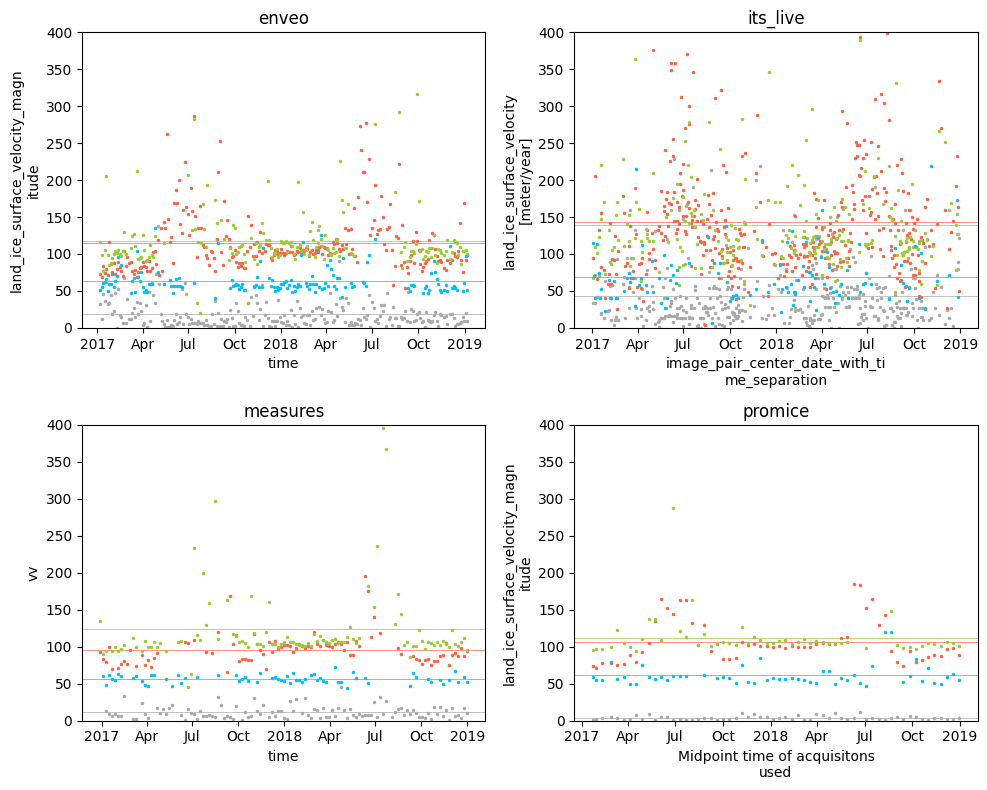

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(nrows=2, ncols=2, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
axs = [ax0, ax1, ax2, ax3]

stid_cmap = {
    "KAN_B": "darkgrey",
    "KAN_L": "tomato",
    "KAN_M": "yellowgreen",
    "KAN_U": "deepskyblue",
}

enveo_ds = xr.open_dataset(
    "./data/velocity/enveo/gis_iv_250m_s1_s20170101_e20211231_v1_2_russell_repeat.nc"
)
itslive_ds = xr.open_dataset(
    "./data/velocity/its_live/gis_iv_itslive_s20170101_e20181231_russell.nc"
)
itslive_ds = itslive_ds.where(
    # (itslive_ds.date_dt.dt.days <= 31)
    (itslive_ds.date_dt.dt.days.isin([6, 12]))
    & (itslive_ds.satellite_img1.str.startswith("1")),
    drop=True,
)
measures_ds = xr.open_dataset(
    "./data/velocity/measures/GL_vel_mosaic_s1cycle_20170101_20181231_v02.0_russell.nc"
)
promice_ds = xr.open_dataset(
    "./data/velocity/promice/gis_iv_s20170101_e20181231_promice_russell.nc"
)

for i, aws in aws_gdf.iterrows():
    x = aws.geometry.x
    y = aws.geometry.y
    stid = aws.stid

    _v_enveo = (
        enveo_ds.sel(x=x, y=y, method="nearest").land_ice_surface_velocity_magnitude
        * 365.25
    )
    _v_itslive = itslive_ds.sel(stid=stid).v
    _v_measures = measures_ds.sel(x=x, y=y, method="nearest").vv
    _v_promice = (
        promice_ds.sel(x=x, y=y, method="nearest").land_ice_surface_velocity_magnitude
        * 365.25
    )

    _v_enveo.plot(ax=ax0, ls="", marker="o", markersize=1.5, c=stid_cmap[stid])
    _v_itslive.plot(ax=ax1, ls="", marker="o", markersize=1.5, c=stid_cmap[stid])
    _v_measures.plot(ax=ax2, ls="", marker="o", markersize=1.5, c=stid_cmap[stid])
    _v_promice.plot(ax=ax3, ls="", marker="o", markersize=1.5, c=stid_cmap[stid])

    ax0.axhline(
        y=_v_enveo.mean(), c=stid_cmap[stid], alpha=0.7, linewidth=0.7, zorder=1
    )
    ax1.axhline(
        y=_v_itslive.mean(), c=stid_cmap[stid], alpha=0.7, linewidth=0.7, zorder=1
    )
    ax2.axhline(
        y=_v_measures.mean(), c=stid_cmap[stid], alpha=0.7, linewidth=0.7, zorder=1
    )
    ax3.axhline(
        y=_v_promice.mean(), c=stid_cmap[stid], alpha=0.7, linewidth=0.7, zorder=1
    )


ax0.set_ylim(bottom=0, top=400)
ax1.set_ylim(bottom=0, top=400)
ax2.set_ylim(bottom=0, top=400)
ax3.set_ylim(bottom=0, top=400)

ax0.set_title("enveo")
ax1.set_title("its_live")
ax2.set_title("measures")
ax3.set_title("promice")

plt.tight_layout()
plt.show()

With the exception of ITS_LIVE, the below plot averages each velocity dataset over the complete AOI (spatially) per month. This is to draw comparison with similar work perfomed by Luke Donaldson for an MPhil dissertation (see https://www.spri.cam.ac.uk/postgraduate/theses/). 

Specifically, Figure 4.1b produces a spatial average over a similar (but not identical) AOI using monthly MEaSUREs data. The plot was to compare the strange velocity pattern observed in 2017 in Luke's plot.

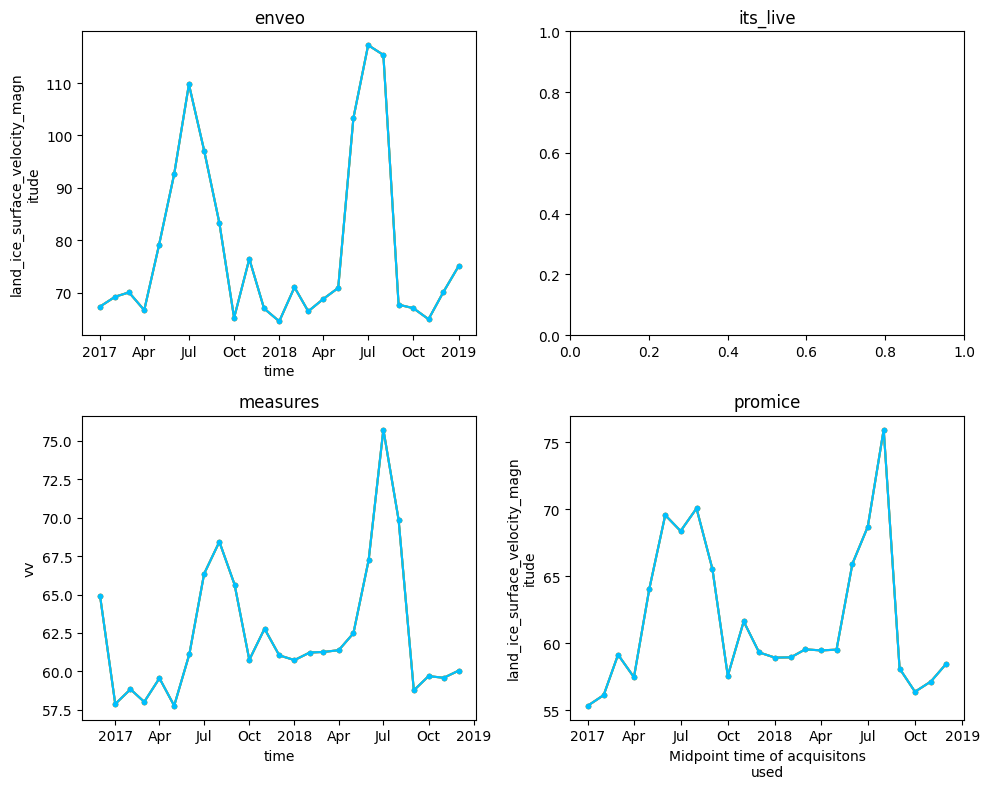

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(nrows=2, ncols=2, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
axs = [ax0, ax1, ax2, ax3]

stid_cmap = {
    "KAN_B": "darkgrey",
    "KAN_L": "tomato",
    "KAN_M": "yellowgreen",
    "KAN_U": "deepskyblue",
}

enveo_ds = xr.open_dataset(
    "./data/velocity/enveo/gis_iv_250m_s1_s20170101_e20211231_v1_2_russell_repeat.nc"
)
itslive_ds = xr.open_dataset(
    "./data/velocity/its_live/gis_iv_itslive_s20170101_e20181231_russell.nc"
)
itslive_ds = itslive_ds.where(
    (itslive_ds.date_dt.dt.days <= 31)
    & (itslive_ds.satellite_img1.str.startswith("1")),
    drop=True,
)
measures_ds = xr.open_dataset(
    "./data/velocity/measures/GL_vel_mosaic_s1cycle_20170101_20181231_v02.0_russell.nc"
)
promice_ds = xr.open_dataset(
    "./data/velocity/promice/gis_iv_s20170101_e20181231_promice_russell.nc"
)

for i, aws in aws_gdf.iterrows():
    x = aws.geometry.x
    y = aws.geometry.y
    stid = aws.stid

    _v_enveo = (
        (enveo_ds.land_ice_surface_velocity_magnitude * 365.25)
        .resample(time="1MS")
        .mean("time")
        .mean(["x", "y"])
    )
    _v_measures = measures_ds.vv.resample(time="1MS").mean("time").mean(["x", "y"])
    _v_promice = (
        (promice_ds.land_ice_surface_velocity_magnitude * 365.25)
        .resample(time="1MS")
        .mean("time")
        .mean(["x", "y"])
    )

    _v_enveo.plot(ax=ax0, ls="-", marker="o", markersize=3, c=stid_cmap[stid])
    _v_measures.plot(ax=ax2, ls="-", marker="o", markersize=3, c=stid_cmap[stid])
    _v_promice.plot(ax=ax3, ls="-", marker="o", markersize=3, c=stid_cmap[stid])


ax0.set_title("enveo")
ax1.set_title("its_live")
ax2.set_title("measures")
ax3.set_title("promice")

plt.tight_layout()
plt.show()

# GPS validation

To provide some external validation of the satellite-derived velocity datasets accessed above, here we derive ice velocity from sub-daily GPS measurements recorded by the PROMICE automatic weather stations.

This attempts to implement a method previously used to validate PROMICE ice velocity data, given [here](https://essd.copernicus.org/articles/13/3491/2021/#section7:~:text=daily%20positions%20of%20the%20GPS%20stations%20are%20calculated%20as%20a%20mean%20of%20the%20hourly%20positions%20for%20each%20day.%20The%20velocity%20components%20are%20estimated%20using%20a%20weighted%20linear%20regression%20for%20each%20of%20the%2024%E2%80%89d%20time%20spans%20of%20the%20velocity%20mosaics%20using%20the%20daily%20positions.).

The PROMICE AWS data is available and documented via the GEUS Dataverse (https://dataverse.geus.dk/dataset.xhtml?persistentId=doi:10.22008/FK2/IW73UU) although here we access the most up-to-date data via their THREDDS Data Server (https://thredds.geus.dk/thredds/catalog/catalog.html).

## Access GPS data

To start with, we will compare satellite-derived ENVEO velocities with GPS data from `KAN_M`.

As with the other PROMICE data, these GPS data are already formatted nicely in NETCDF format. All we do here is load the data via the URL, discard unneeded variables, and subset to the years 2017 and 2018.

A local copy is saved to the file:

`./data/gps/kan_m_hour.nc`

Finally, we create daily averages of GPS position from the sub-daily measurements.

In [161]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pyproj
import geopandas as gpd

aws_gdf = gpd.read_file("./data/gps/aws.geojson").to_crs(3413).set_index("stid")
aws_gdf = aws_gdf.loc[aws_gdf.index == "KAN_M"]

aws_l2 = xr.open_dataset(
    "https://thredds.geus.dk/thredds/dodsC/aws/l2stations/netcdf/hour/KAN_M_hour.nc"
)

del aws_l2.attrs["_NCProperties"]
aws_gps = aws_l2[["gps_lat", "gps_lon"]]
aws_gps = aws_gps.sel(time=slice("2017-01-01", "2018-12-31"))
aws_gps = aws_gps.load()

aws_gps_lon = aws_gps.gps_lon.values
aws_gps_lat = aws_gps.gps_lat.values

transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3413", always_xy=True)
gps_x, gps_y = transformer.transform(aws_gps_lon, aws_gps_lat)

aws_gps["gps_x"] = ("time", gps_x.data)
aws_gps["gps_y"] = ("time", gps_y.data)

aws_gps = aws_gps.resample(time="D").mean()
aws_gps = aws_gps.dropna("time")

## Calculate GPS velocities

Here, we use the start and end datetimes of each ENVEO velocity measurement to produce a GPS velocity. Specifically, for each ENVEO image-pair we take all daily GPS measurements within that period and perform a linear regression on the x and y GPS positions to derive x and y component velocities. 

From these components, we calculate velocity magnitude. For comparison, we query the ENVEO velocity magnitude dataset at the location of the mean GPS position within each image-pair period. 

In [ ]:
enveo_ds = xr.open_dataset(
    "./data/velocity/enveo/gis_iv_250m_s1_s20170101_e20211231_v1_2_russell_repeat.nc"
)
enveo_ds = enveo_ds.sel(time=slice("2017-01-01", "2018-12-31"))

vx_components = []
vy_components = []
enveo_vv = []
i = 0

for start, end in enveo_ds.time_bnds.values:
    # Select the data for the time period
    period_data = aws_gps.sel(stid="KAN_M", time=slice(start, end))

    # Perform linear regression for x and y coordinates
    time_days = (
        period_data.time.values - np.datetime64("1970-01-01")
    ) / np.timedelta64(1, "D")

    slope_x, _, _, _, _ = scipy.stats.linregress(time_days, period_data.gps_x.values)
    slope_y, _, _, _, _ = scipy.stats.linregress(time_days, period_data.gps_y.values)

    # Append the calculated slopes (velocities in meters per day)
    vx_components.append(slope_x)
    vy_components.append(slope_y)

    mean_x = period_data.gps_x.mean().values
    mean_y = period_data.gps_y.mean().values
    enveo_vv_sel = (
        enveo_ds.isel(time=i)
        .sel(x=mean_x, y=mean_y, method="nearest")
        .land_ice_surface_velocity_magnitude.values
    )

    enveo_vv.append(enveo_vv_sel)

    i += 1

# Combine velocities into a single dataset
vx = np.array(vx_components)
vy = np.array(vy_components)
vv = np.sqrt(vx**2 + vy**2)  # Magnitude of velocity

enveo_ds["gps_vv"] = ("time", vv)
enveo_ds["vv_sel"] = ("time", enveo_vv)


## Compare GPS and satellite derived velocities

Finally, we plot GPS derived velocity magnitude and ENVEO satellite-derived velocity magnitude against time to compare. In the below plot, GPS data is **blue** and satellite ENVEO data is **red**. The vertical scale is velocity magnitude in metres per day.

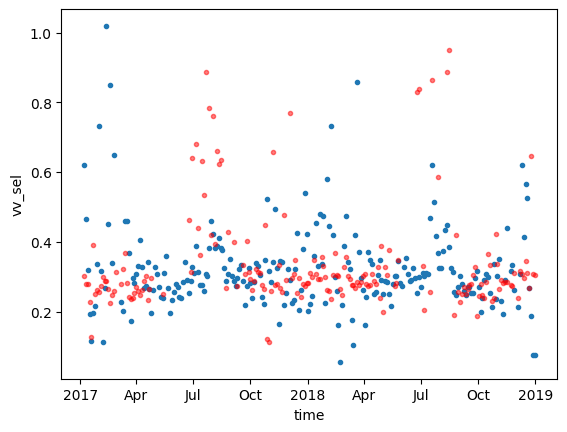

In [162]:
enveo_ds.gps_vv.plot(ls="", marker="o", markersize=3)
enveo_ds.vv_sel.plot(ls="", marker="o", markersize=3, c="red", alpha=0.5)

For reference, here is the plot of GPS derived velocity magnitude **against** ENVEO satellite-derived velocity magnitude.

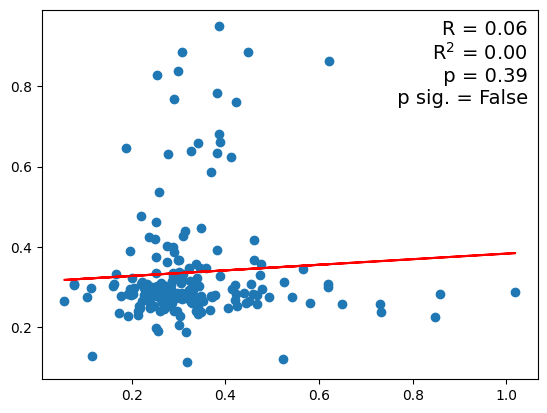

In [154]:
# Mask null values
mask = enveo_ds.gps_vv.notnull() & enveo_ds.vv_sel.notnull()
xx = enveo_ds.gps_vv.where(mask, drop=True)
yy = enveo_ds.vv_sel.where(mask, drop=True)

res = scipy.stats.linregress(xx, yy)

plt.scatter(xx, yy, marker="o")
plt.plot(xx, res.intercept + res.slope * xx, "r", label="fitted line")
from matplotlib.offsetbox import AnchoredText

# Add R2 and p values to plot
plt.gca().add_artist(
    AnchoredText(
        f"R = {res.rvalue:.2f}\n R$^{{2}}$ = {res.rvalue**2:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
        loc="upper right",
        borderpad=0.1,
        prop=dict(fontsize=14, horizontalalignment="right"),
        frameon=False,
    )
)

The following two plots perform the same comparison for the MEaSUREs data.

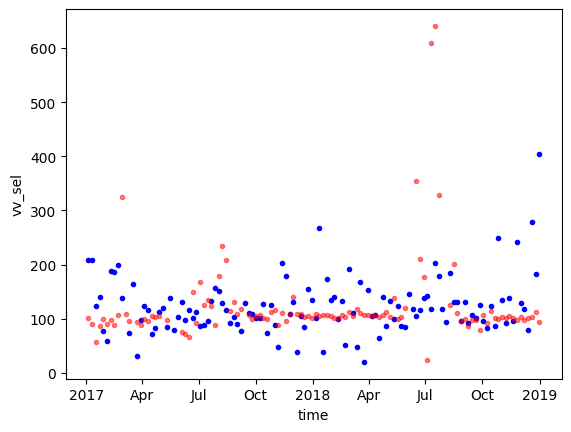

In [188]:
(measures_ds.gps_vv * 365.25).plot(ls="", marker="o", c="blue", markersize=3)
measures_ds.vv_sel.plot(ls="", marker="o", markersize=3, c="red", alpha=0.5)

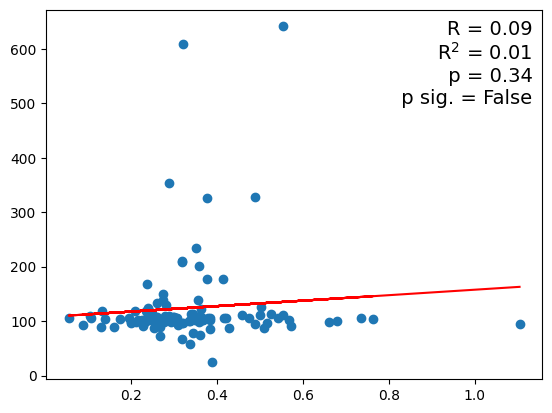

In [192]:
# Mask null values
mask = measures_ds.gps_vv.notnull() & measures_ds.vv_sel.notnull()
xx = measures_ds.gps_vv.where(mask, drop=True)
yy = measures_ds.vv_sel.where(mask, drop=True)

res = scipy.stats.linregress(xx, yy)

plt.scatter(xx, yy, marker="o")
plt.plot(xx, res.intercept + res.slope * xx, "r", label="fitted line")
from matplotlib.offsetbox import AnchoredText

# Add R2 and p values to plot
plt.gca().add_artist(
    AnchoredText(
        f"R = {res.rvalue:.2f}\n R$^{{2}}$ = {res.rvalue**2:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
        loc="upper right",
        borderpad=0.1,
        prop=dict(fontsize=14, horizontalalignment="right"),
        frameon=False,
    )
)